In [45]:
import os
os.environ["WORKING_DIR"] = './'
os.environ["FRAMES_PER_BATCH"] = "10"
os.environ["BATCH_SIZE"] = "1" #"22,12,6,3"
os.environ["EPOCHS"] = "2"
os.environ["FILTERS_COUNT"] = "2"#"120" #"32,64,120,200"
os.environ["DATA_SPLIT"] = "251"
os.environ["MOD_VERSION"] = "v8.1"
os.environ["MODEL_PATH"] = os.environ["WORKING_DIR"] + "models/" + os.environ["MOD_VERSION"] + \
    "/image_pred_" + os.environ["MOD_VERSION"] +".keras"
!mkdir -p ${WORKING_DIE}models/${MOD_VERSION}
!mkdir -p ${WORKING_DIE}loss_plots/${MOD_VERSION}

In [ ]:
import tensorflow as tf
print(tf.__version__)

!pip install mediapy

In [3]:
# %%bash
# pip install gdown
# mkdir ${WORKING_DIR}models
# mkdir ${WORKING_DIR}loss_plots
# rm -rf ${WORKING_DIR}train
# mkdir -p ${WORKING_DIR}train/images
# cd ${WORKING_DIR}train
# gdown https://drive.google.com/uc?id=1RVtu5pF2uTMhaXdiwL6Gq85thuxREqdI
# unzip ./resized_images.zip -d ${WORKING_DIR}train/images
# cd ./images
# mv ./resized_images/* .
# rm -rf resized_images
# ls ${WORKING_DIR}train/images

In [9]:
import os

# 1000 - 0.5 blur
# 2000 - 1.0 blur
# 3000 - brigthness
# 4000 - darnkess

images_path = os.environ["WORKING_DIR"] +"train/images/"
images = os.listdir(images_path)
ordered = [int(f[:-4]) for f in images]
ordered.sort()
ordered = [str(f)+".png" for f in ordered]

for im in ordered:
    !convert -blur 0x0.5 {images_path}{im} {images_path}{int(im[:-4])+1000}{im[-4:]}
    !convert -blur 0x1 {images_path}{im} {images_path}{int(im[:-4])+2000}{im[-4:]}
    !convert -brightness-contrast 20X10 {images_path}{im} {images_path}{int(im[:-4])+3000}{im[-4:]}
    !convert -brightness-contrast -20X10 {images_path}{im} {images_path}{int(im[:-4])+4000}{im[-4:]}

In [72]:
%%writefile {os.environ["WORKING_DIR"]}preprocess_data.py

import tensorflow as tf
import os
import numpy as np
import random

def pre_process():
    # Load and order images in array
    images_path = os.environ["WORKING_DIR"] +"train/images/"
    images = os.listdir(images_path)
    ordered = [int(f[:-4]) for f in images]
    ordered.sort()
    ordered = [str(f)+".png" for f in ordered]

    # Make features and labels
    def img_preprocess(path):
        imd = tf.image.decode_png(tf.io.read_file(path), channels=1)
        if random.randint(1,3) == 3:
            if random.randint(1,2) == 2:
                imd = tf.image.adjust_brightness(imd, random.uniform(-0.4, -0.2))
            else:
                imd = tf.image.adjust_brightness(imd, random.uniform(0.2, 0.4))

        #imd = tf.image.resize(imd, [360, 640])
        imd = tf.cast(imd, tf.float32)
        imd = imd / 255
        return imd

    frames_per_batch = int(os.environ["FRAMES_PER_BATCH"])
    data_split = int(os.environ["DATA_SPLIT"])
    train_data = [[]]
    train_labels = [[]]
    test_data = [[]]
    test_labels = [[]]
    train_batch_i = 0
    test_batch_i = 0

    for idx, im in enumerate(ordered):
        imdx = int(im[:-4])
                    
        if imdx in [300]:
            continue

        if idx != 0 and idx % frames_per_batch == 0:
            if imdx >= data_split:
                test_batch_i += 1
                test_data.append([])
                test_labels.append([])
            else:
                train_batch_i += 1
                train_data.append([])
                train_labels.append([])

        if imdx >= data_split:
            test_data[test_batch_i].append(img_preprocess(images_path + im))
            test_labels[test_batch_i].append(img_preprocess(images_path + str(imdx+1) + im[-4:]))
        else:
            train_data[train_batch_i].append(img_preprocess(images_path + im))
            train_labels[train_batch_i].append(img_preprocess(images_path + str(imdx+1) + im[-4:]))

    # Remove batches with wrong size
    def remove_wrong_length_batches(l):
        idx_to_remove = []
        for idx, f in enumerate(l):
            if len(f) != frames_per_batch:
                idx_to_remove.append(idx)
        for i, idx in enumerate(idx_to_remove):
            l.pop(idx-i)
        return l
    
    test_data = remove_wrong_length_batches(test_data)
    test_labels = remove_wrong_length_batches(test_labels)

    print("frames per batch: ", len(train_data[0]))
    print("Shape: ", train_data[0][0].shape)
    print("Train feature length: ", len(train_data))
    print("Train label length: ", len(train_labels))
    print("Test Feature length: ", len(test_data))
    print("Test Labels length: ", len(test_labels))   

    dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    return dataset, train_data, train_labels, test_data, test_labels

Overwriting ./preprocess_data.py


In [53]:
%%writefile {os.environ["WORKING_DIR"]}train.py

import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import sys

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import preprocess_data

def build_and_train(dataset, filters, batch_size, model_path=os.environ["MODEL_PATH"]):
    dataset = dataset.batch(batch_size).prefetch(1)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.ConvLSTM2D(
            filters=filters,
            kernel_size=(5, 5),
            padding="same",
            return_sequences=True,
            activation="relu",
            dropout=myDO,
            recurrent_dropout=myDO
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(
            filters=filters,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
            dropout=myDO,
            recurrent_dropout=myDO
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(
            filters=filters,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
            dropout=myDO,
            recurrent_dropout=myDO
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(
            filters=filters,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
            dropout=myDO,
            recurrent_dropout=myDO
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(
            filters=filters,
            kernel_size=(1, 1),
            padding="same",
            return_sequences=True,
            activation="relu",
            dropout=myDO,
            recurrent_dropout=myDO
        ),
        tf.keras.layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')

    history = model.fit(dataset, epochs=int(os.environ["EPOCHS"]))
    model.save(model_path)

    # Plot learning curves
    history_dict = history.history
    loss_values = history_dict["loss"]
    epochs = range(1, len(loss_values) + 1)
    loss_plot_filename = model_path.split("/")[-1] + "_loss_plot.png"

    plt.plot(epochs, loss_values, "b", label="Training loss") 
    plt.title("Training loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.environ["WORKING_DIR"] + "loss_plots/" + os.environ["MOD_VERSION"] + "/" + loss_plot_filename)
    plt.clf()

# Build model
myDO = 0.3
dataset, _, _, _, _ = preprocess_data.pre_process()

if len(os.environ["FILTERS_COUNT"]) > 4:
    filters = [int(f) for f in os.environ["FILTERS_COUNT"].split(",")]
    batch_sizes = [int(f) for f in os.environ["BATCH_SIZE"].split(",")]

    for idx, filter in enumerate(filters):
        build_and_train(dataset, filter, batch_sizes[idx], 
            model_path=os.environ["MODEL_PATH"][:-6] + "_filters" + str(filter) + 
            os.environ["MODEL_PATH"][-6:])
else:
    build_and_train(dataset, int(os.environ["FILTERS_COUNT"]), int(os.environ["BATCH_SIZE"]))

Overwriting ./train.py


In [52]:
%cd {os.environ["WORKING_DIR"]}
!python {os.environ["WORKING_DIR"]}train.py

/home/carlos/Projects/image_pred
2024-05-01 16:57:48.462624: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 16:57:48.486198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
frames per batch:  10
Shape:  (203, 360, 1)
Train feature length:  25
Train label length:  25
Test Feature length:  4
Test Labels length:  4
Tensor("args_0:0", shape=(10, 203, 360, 1), dtype=float32)
Tensor("args_1:0", shape=(10, 203, 360, 1), dtype=float32)
test
Epoch 1/2
25/25 [==============================] - 20s 494ms/step - loss: 0.7056
Epoch 2

/home/carlos/Projects/image_pred/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/carlos/Projects/image_pred
frames per batch:  10
Shape:  (203, 360, 1)
Train feature length:  25
Train label length:  25
Test Feature length:  4
Test Labels length:  4


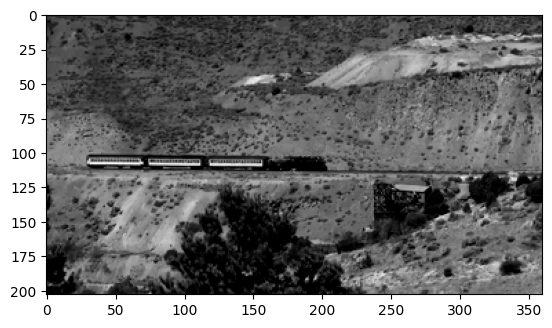

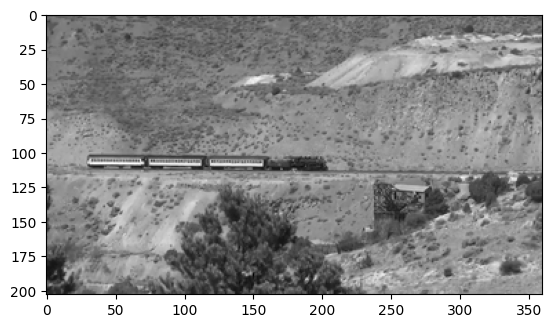

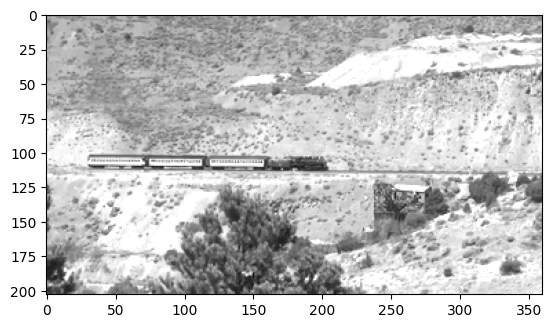

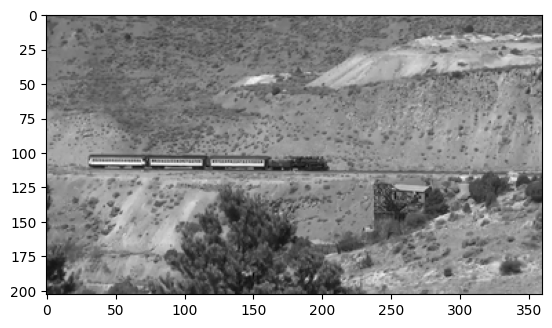

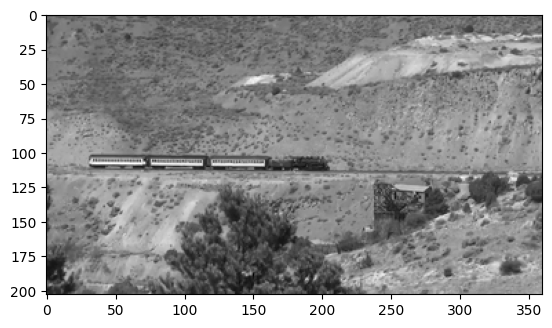

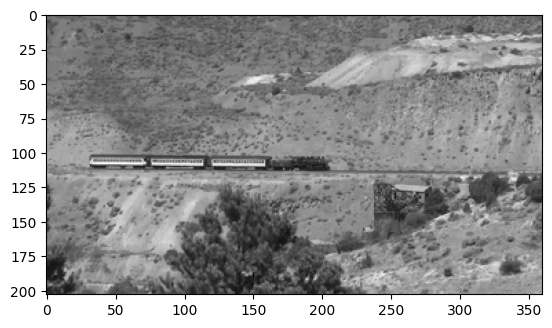

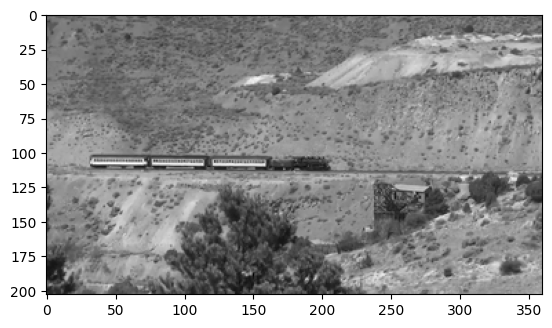

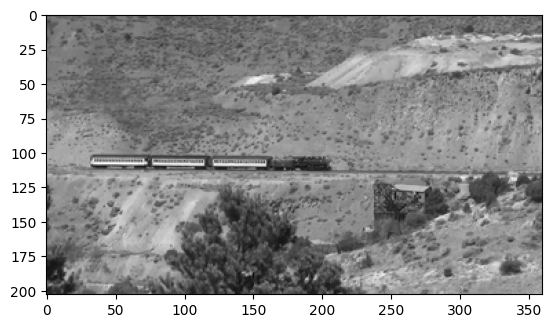

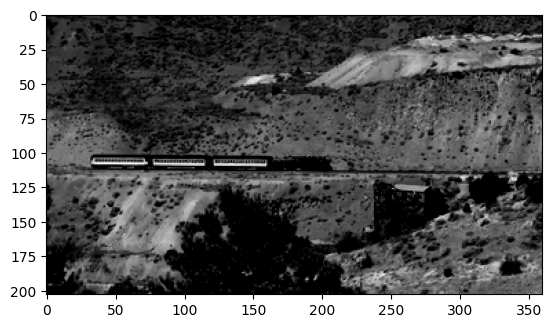

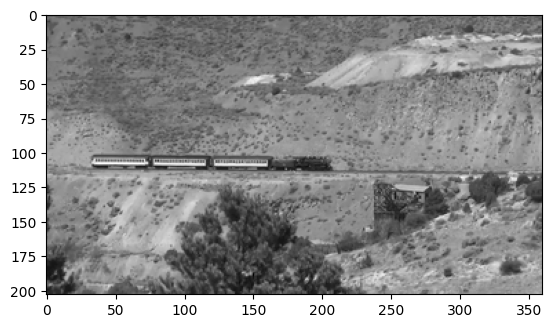

In [73]:
%cd {os.environ["WORKING_DIR"]}
import sys
import tensorflow as tf
import os

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from importlib import reload
import preprocess_data

reload(preprocess_data)
dataset, train_data, train_labels, test_data, test_labels = preprocess_data.pre_process()

import matplotlib.pyplot as plt

for im in train_data[0]:
    plt.imshow(im, cmap='gray')
    plt.show()


# Multiple models

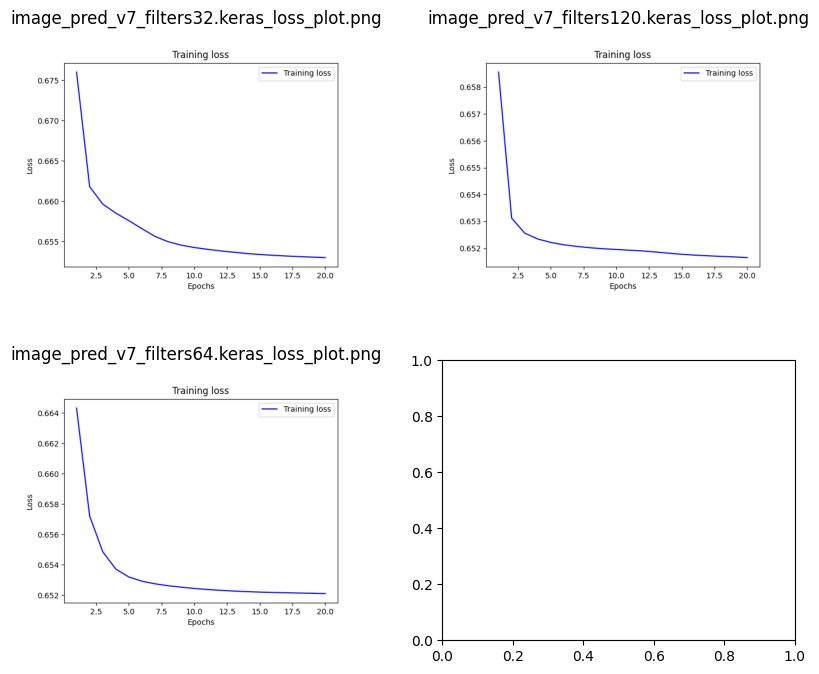

In [4]:
# Plot losses
import matplotlib.pyplot as plt
import os

loss_plots_path = os.environ["WORKING_DIR"] + "loss_plots/" + os.environ["MOD_VERSION"] + "/"
losses = os.listdir(loss_plots_path)
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(10)
fig.set_figheight(8)
row = 0
col = 0

for l in losses:
    cax = ax[row, col]
    cax.imshow(plt.imread(loss_plots_path + l))
    cax.axis(False)
    cax.set_title(l)
    row += 1

    if row == 2:
        row = 0
        col = 1

image_pred_v7_filters64.keras
1/1 [==============================] - 1s 730ms/step
image_pred_v7_filters120.keras
1/1 [==============================] - 1s 1s/step
image_pred_v7_filters32.keras
1/1 [==============================] - 0s 447ms/step


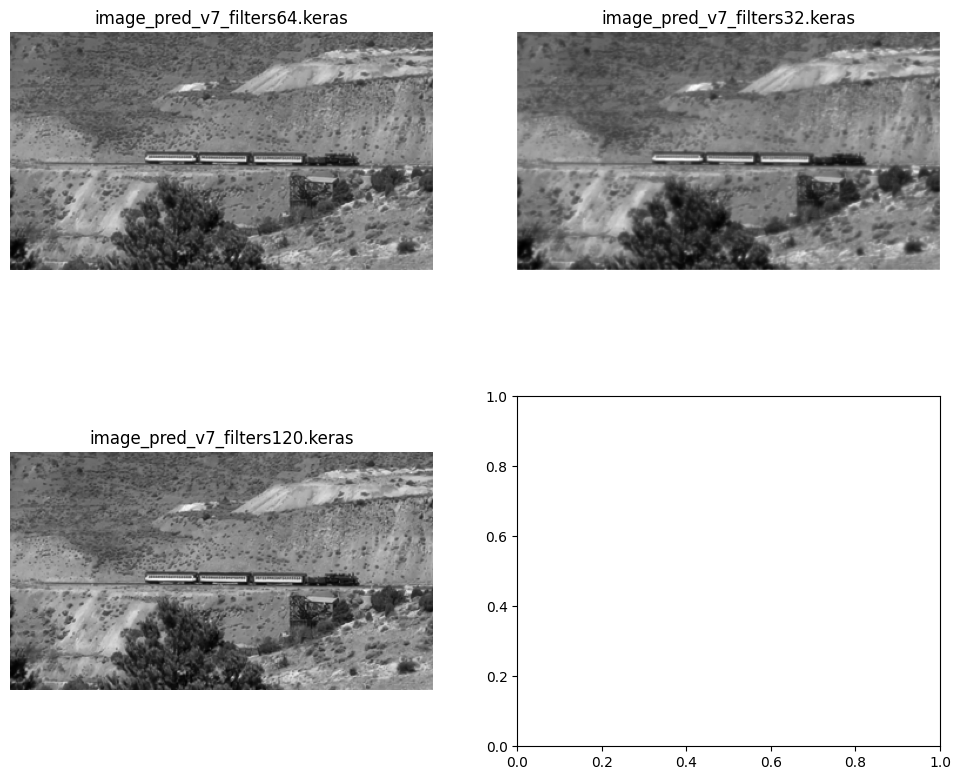

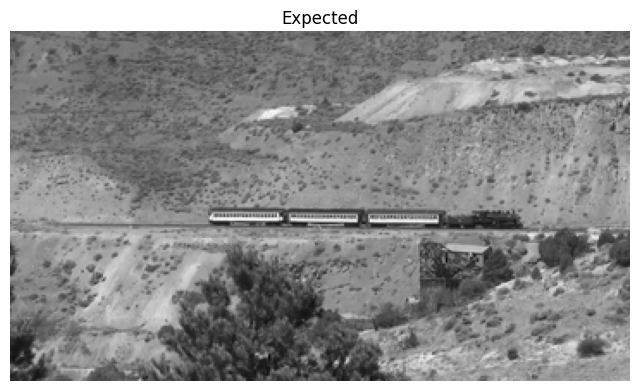

In [5]:
# Plot pictures
models_path = os.environ["WORKING_DIR"] + "models/" + os.environ["MOD_VERSION"] + "/"
models = os.listdir(models_path)
fig, ax = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
row = 0
col = 0
for m in models:
    print(m)
    lmodel = tf.keras.models.load_model(models_path + m)
    test = tf.expand_dims(test_data[0], 0)
    pred = lmodel.predict(test)

    cax = ax[row, col]
    cax.imshow(pred[0][0][..., -1], cmap='gray')
    cax.axis(False)
    cax.set_title(m)
    row += 1

    if row == 2:
        row = 0
        col = 1

plt.figure(figsize=(8, 6))
plt.imshow(test_labels[0][0][:, :, -1], cmap="gray")
plt.title("Expected")
plt.axis(False)
plt.show()

In [6]:
# Generate videos
import mediapy as media
import numpy as np

def normalize(pre):
    return (pre - np.min(pre))/np.ptp(pre)

models_path = os.environ["WORKING_DIR"] + "models/" + os.environ["MOD_VERSION"] + "/"
models = os.listdir(models_path)
batches_to_pred = 20
pred_frames_all = []

for m in models:
    lmodel = tf.keras.models.load_model(models_path + m)
    test = tf.expand_dims(test_data[0], 0)
    pred = lmodel.predict(test)

    label_frames = []
    pred_frames = []

    for i in range(batches_to_pred):
        test = tf.expand_dims(test_data[i], 0)
        pred = lmodel.predict(test)
        label_frames += [t.numpy()[..., -1] for t in test_labels[i]]
        pred_frames += [normalize(p[..., -1]) for p in pred[0]]

    def plot_img(img):
        plt.figure(figsize=(10, 6))
        plt.imshow(img, interpolation='nearest', cmap='gray')
        plt.axis(False)
        plt.title("Original")
        plt.show()

    pred_frames_all.append([m, pred_frames])
media.show_video(label_frames, fps=5, title="Expected")

for p in pred_frames_all:
    media.show_video(p[1], fps=5, title=p[0])

1/1 [==============================] - 0s 151ms/step


In [7]:
batches_to_pred = 6
pred_frames_all = []
label_frames = []

for i in range(batches_to_pred):
    label_frames += [t.numpy()[..., -1] for t in test_labels[i]]

for m in models:
    lmodel = tf.keras.models.load_model(models_path + m)
    test = tf.expand_dims(test_data[0], 0)

    # Predict recursivly
    pred_frames = []

    for i in range(batches_to_pred):
        if i == 0:
            data = test_data[0]
            data = tf.expand_dims(data, 0)
        data = lmodel.predict(data)
        pred_frames += [normalize(p[..., -1]) for p in data[0]]
    pred_frames_all.append([m, pred_frames])

media.show_video(label_frames, fps=2, title="Expected")

for p in pred_frames_all:
    media.show_video(p[1], fps=2, title=p[0])

1/1 [==============================] - 0s 169ms/step


# One model

In [4]:
lmodel = tf.keras.models.load_model(os.environ["MODEL_PATH"])

(-0.5, 639.5, 479.5, -0.5)

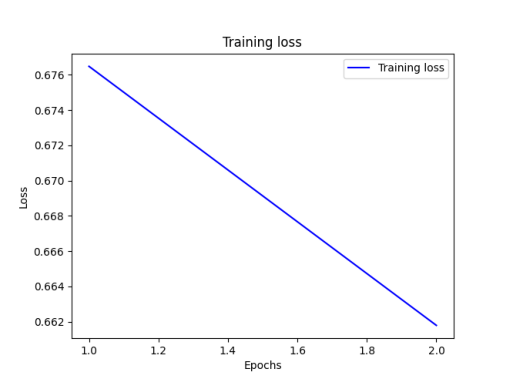

In [5]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(os.environ["WORKING_DIR"] + "loss_plots/" + os.environ["MOD_VERSION"] + "/" +
                        os.environ["MODEL_PATH"].split("/")[-1] + "_loss_plot.png"))
plt.axis(False)

In [7]:

import mediapy as media
import numpy as np

def normalize(pre):
    return (pre - np.min(pre))/np.ptp(pre)

batches_to_pred = 2
label_frames = []
pred_frames = []

for i in range(batches_to_pred):
    test = tf.expand_dims(test_data[i], 0)
    pred = lmodel.predict(test)
    label_frames += [t.numpy()[..., -1] for t in test_labels[i]]
    pred_frames += [normalize(p[..., -1]) for p in pred[0]]

def plot_img(img):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, interpolation='nearest', cmap='gray')
    plt.axis(False)
    plt.title("Original")
    plt.show()


media.show_video(label_frames, fps=5, title="Expected")
media.show_video(pred_frames, fps=5, title='Predicted')

1/1 [==============================] - 1s 694ms/step


In [8]:
# Predict recursivly
batches_to_pred = 8
label_frames = []
pred_frames = []

for i in range(3):
    label_frames += [t.numpy()[..., -1] for t in test_labels[i]]

for i in range(batches_to_pred):
    if i == 0:
        data = test_data[0]
        data = tf.expand_dims(data, 0)
    pred = lmodel.predict(data)
    data = np.append(data, [[pred[0][-1]]], axis=1)

pred_frames += [normalize(p[..., -1]) for p in data[0]]

def plot_img(img):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, interpolation='nearest', cmap='gray')
    plt.axis(False)
    plt.title("Original")
    plt.show()

print(len(pred_frames))
media.show_video(label_frames, fps=2, title="Expected")
media.show_video(pred_frames, fps=2, title='Predicted')

1/1 [==============================] - 1s 1s/step
18


In [45]:
import mediapy as media

def prep_frames(data):
    frames = []
    for b in data:
        for img in b:
            frames.append(img.numpy()[:, :, -1])
    return frames

media.show_video(prep_frames(train_data), fps=10, title="Train data")
media.show_video(prep_frames(test_data), fps=10, title="Test data")